# Caricamento dei modelli:

### 1) SAM2

In [1]:
import shutil
import matplotlib
from groundingdino.util.inference import load_model, load_image, predict, annotate

import numpy as np
import torchvision.transforms as transforms
from sklearn.ensemble import IsolationForest
from torchvision.ops import box_convert
import os
from scipy.ndimage import generic_filter
import utility

# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch
import torchvision
import cv2
from matplotlib import pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2, build_sam2_video_predictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator, SAM2ImagePredictor

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")



if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs
    # (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

# loading sam paramters
sam2_checkpoint = "./checkpoints/sam2.1_hiera_tiny.pt"
model_cfg_path = "configs/sam2.1/sam2.1_hiera_t.yaml"


using device: cpu


In [3]:
device = device
sam2 = build_sam2(model_cfg_path, sam2_checkpoint, device=device)
# mask_generator = SAM2AutomaticMaskGenerator(
#     sam2,
#     points_per_side=32,  # Increase for more detailed segmentation
#     pred_iou_thresh=0.7,  # Adjust threshold based on your needs 0.86 def
#     stability_score_thresh=0.92,
#     stability_score_offset=0.7,
#     crop_n_layers=1,
#     crop_n_points_downscale_factor=2
# )
image_predictor = SAM2ImagePredictor(sam2)
video_predictor = build_sam2_video_predictor(model_cfg_path, sam2_checkpoint, device=device)

### 2) Grounding DINO

In [4]:
model = load_model("groundingdino/config/GroundingDINO_SwinT_OGC.py", "weights/groundingdino_swint_ogc.pth",device)
#IMAGE_PATH = ""
TEXT_PROMPT = "object ."
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

final text_encoder_type: bert-base-uncased


## Utilizzo su Dataset 'FLOSH'


In [7]:
from utility import *
print(os.getcwd())  # This prints the current directory

# Where to retrive images
folder_path = "inserimento_oggetti"

# Extract frames
frame_names = [
    p for p in os.listdir(folder_path)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
# Sorting frames
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0].split('_')[-1]))

#setting the railway box
railway_box = np.array([0, 256, 640, 512])

# Setting statistics
gd_iou, h_iou, otsu_iou = 0, 0, 0
gd_dice , h_dice, otsu_dice = 0, 0, 0
gd_precision , h_precision, otsu_precision = 0, 0, 0
gd_recall, h_recall, otsu_recall = 0, 0, 0

n_frames = 0
skipped = 0

try:
    for p in frame_names:
        print('----------------------')
        image =  cv2.imread(os.path.join(folder_path, p))
        ground_truth = cv2.imread(utility.find_corresponding_segmentation(p, 'segmentazione_oggetti'), cv2.IMREAD_GRAYSCALE)

        if cv2.countNonZero(ground_truth) < 170:
            print("oggetto troppo piccolo")
            skipped += 1
            continue

        if n_frames % 20 == 0:
            print("frame saltati: ", skipped)

        name = str(p)
        print("Analyzing image:", name)
        print()
        image_predictor.set_image(image)

        object_mask_gd, m_h, m_l = None, None, None
        n_frames += 1

        ### GROUNDING DINO + SAM 2 METHOD


        # Finding objects in the bounding box with Grounding DINO
        image_source, gd_image = load_image(folder_path+'/'+name)

        gd_boxes, logits, phrases = predict(
            model=model,
            image=gd_image,
            caption=TEXT_PROMPT,
            box_threshold=BOX_TRESHOLD,
            text_threshold=TEXT_TRESHOLD,
            device=device,
        )

        h, w, _ = image_source.shape
        gd_boxes = gd_boxes * torch.Tensor([w, h, w, h])
        gd_boxes = box_convert(boxes=gd_boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()

        for box in gd_boxes:
            if utility.is_contained(box, railway_box,1):
                object_mask_gd, score_gd, _ = image_predictor.predict(
                    box=box,
                    multimask_output=False,
                )
                # salvataggio dell'immagine
                utility.show_masks(image, object_mask_gd, score_gd,borders=False,show=False,savefig=True,save_path="debug/gd2/",
                                   save_name=name,box_coords=box)


                statistics_map_gd = utility.segmentation_metrics(object_mask_gd, ground_truth)
                for metric in statistics_map_gd:
                    if metric == 'IoU':
                        gd_iou += statistics_map_gd[metric]
                    elif metric == 'Dice':
                        gd_dice += statistics_map_gd[metric]
                    elif metric == 'Precision':
                        gd_precision += statistics_map_gd[metric]
                    elif metric == 'Recall':
                        gd_recall += statistics_map_gd[metric]

        print("Grounding Dino - frame: ",n_frames, ", IoU: ", gd_iou/n_frames, ", Dice: ", gd_dice/n_frames,
              ", Precision: ", gd_precision/n_frames, ", Recall: ", gd_recall/n_frames)




        ### HOLES METHOD



        # Creating a grid of points for the railway's mask
        points ,labels = utility.create_grid(railway_box, points_per_row=[3, 4, 5])

        masks, scores, logits = image_predictor.predict(
            point_coords=points,
            point_labels=labels,
            #box=railway_box,
            multimask_output=False,
            return_logits=True,
        )
        sorted_ind = np.argsort(scores)[::-1]
        masks = masks[sorted_ind]
        scores = scores[sorted_ind]
        logits = logits[sorted_ind]

        # Displaying the image with the grid approach, use the parameters to show or save
        utility.show_masks(image,masks>0,scores,input_labels=labels,point_coords=points,show=False,savefig=True,
                           save_path='debug/grid/',save_name=p)

        l = np.squeeze(masks)
        l[l < 0] = 0

        sigmoid_mask = utility.sigmoid(l)  # Values are now in range [0, 1]

        #Convert to uint8 (0-255 range for OpenCV)
        sigmoid_mask_2d = (sigmoid_mask * 255).astype(np.uint8)  # Shape: (1, H, W)

        sig = (sigmoid_mask_2d > 127).astype(np.uint8) # binarify the mask to search for holes

        coord_holes, holes_labels = utility.find_holes(sig, 100)

        if len(coord_holes)>0:

            m_h,s_h,_ = image_predictor.predict(
                point_coords=coord_holes,
                point_labels=holes_labels,
                multimask_output=False,
            )
            utility.show_masks(image, m_h, s_h, borders=False, show=False, savefig=True, point_coords=coord_holes,
                               input_labels=holes_labels, save_path='debug/holes/', save_name=name)

            d_h = utility.segmentation_metrics(m_h, ground_truth)
            for metric in d_h:
                if metric == 'IoU':
                    h_iou += d_h[metric]
                elif metric == 'Dice':
                    h_dice += d_h[metric]
                elif metric == 'Precision':
                    h_precision += d_h[metric]
                elif metric == 'Recall':
                    h_recall += d_h[metric]

        print("Holes - frame: ", n_frames, ", IoU: ", h_iou / n_frames, ", Dice: ", h_dice / n_frames, ", Precision: ", h_precision / n_frames, ", Recall: ", h_recall / n_frames)



        ###  OTSU METHOD

        #Creating an high-pass filter upon railway mask logits using OTSU for the calculation of the threshold

        thresh_val, binary_mask = cv2.threshold(sigmoid_mask_2d, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        binary_mask[binary_mask > 127] = 1


        if binary_mask.dtype != np.uint8:
            binary_mask = binary_mask.astype(np.uint8)


        coord_holes, o_labels = utility.find_holes(binary_mask, 100)
        if len(coord_holes) > 0:
            m_o, s_o, _ = image_predictor.predict(
                point_coords=coord_holes,
                point_labels=o_labels,
                multimask_output=False,
            )
            utility.show_masks(image, m_o, np.array([0]), borders=False, point_coords=coord_holes, input_labels=o_labels,
                               show=False, savefig=True, save_path='debug/otzu/', save_name=name)

            d_o = utility.segmentation_metrics(m_o, ground_truth)
            for metric in d_o:
                if metric == 'IoU':
                    otsu_iou += d_o[metric]
                elif metric == 'Dice':
                    otsu_dice += d_o[metric]
                elif metric == 'Precision':
                    otsu_precision += d_o[metric]
                elif metric == 'Recall':
                    otsu_recall += d_o[metric]


        print("Otsu - frame: ", n_frames, ", IoU: ", otsu_iou / n_frames, ", Dice: ", otsu_dice / n_frames,
              ", Precision: ", otsu_precision / n_frames, ", Recall: ", otsu_recall / n_frames)
except(KeyboardInterrupt, SystemExit):
    print("Exiting...")
    print('iou', gd_iou, h_iou, otsu_iou)
    print('dice', gd_dice, h_dice, otsu_dice)
    print('precision', gd_precision, h_precision, otsu_precision)
    print('recall', gd_recall, h_recall, otsu_recall)
    print('n_frames ', n_frames)
    print('skipped ',skipped)

/Users/elionkaraboja/Desktop/LAUREA/proj
----------------------
frame saltati:  0
Analyzing image: inserimento_oggetti_00000.jpg

Grounding Dino - frame:  1 , IoU:  0.0 , Dice:  0.0 , Precision:  0.0 , Recall:  0.0
Holes - frame:  1 , IoU:  0.08871339635692875 , Dice:  0.1629692381002806 , Precision:  0.09096282286187127 , Recall:  0.7820121951219512
Otsu - frame:  1 , IoU:  0.0 , Dice:  0.0 , Precision:  0.0 , Recall:  0.0
----------------------
Analyzing image: inserimento_oggetti_00001.jpg

Exiting...
iou 0 0.08871339635692875 0.0
dice 0 0.1629692381002806 0.0
precision 0 0.09096282286187127 0.0
recall 0 0.7820121951219512 0.0
n_frames  2
skipped  0


## Utilizzo su Video (Grounding DINO + SAM2)


In [5]:
#rd.video_analysis('s_c_f','seg_new_video', model)

video_dir = 's_c_f'
segmented_video_dir = 'seg_new_video'


frame loading (JPEG): 100%|██████████| 905/905 [00:18<00:00, 48.52it/s]


Analysis with Grounding Dino
['object', 'railway'] tensor([0.5745, 0.7361])
obj_point  [np.float32(498.0), np.float32(319.0)]


propagate in video:   2%|▏         | 14/905 [00:58<1:02:18,  4.20s/it]


Analysis with Grounding Dino
['object', 'object'] tensor([0.6701, 0.3516])
new box  [411.12787 267.33633 448.18005 287.62637]



Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
propagate in video:   2%|▏         | 14/890 [01:30<1:33:55,  6.43s/it]


Analysis with Grounding Dino


['object'] tensor([0.6400])


propagate in video:   0%|          | 0/875 [00:00<?, ?it/s]UserWarning: cannot import name '_C' from 'sam2' (/Users/elionkaraboja/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
propagate in video:   2%|▏         | 14/875 [01:38<1:41:14,  7.06s/it]


Analysis with Grounding Dino


['object', 'object'] tensor([0.7031, 0.4692])


propagate in video:   0%|          | 0/860 [00:00<?, ?it/s]UserWarning: cannot import name '_C' from 'sam2' (/Users/elionkaraboja/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
propagate in video:   1%|          | 8/860 [05:21<9:29:50, 40.13s/it] 

Exiting...


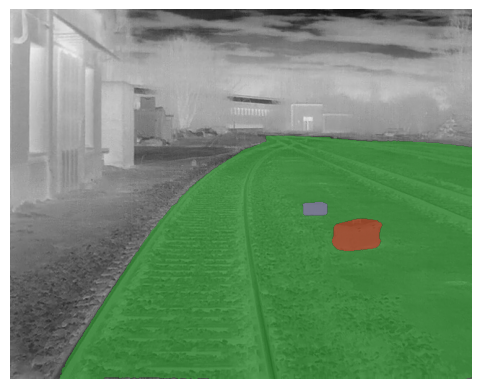

In [7]:
try:
    #Extract frames
    frame_names = [
        p for p in os.listdir(video_dir)
        if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
    ]
    #Sorting frames
    frame_names.sort(key=lambda p: int(os.path.splitext(p)[0].split('_')[-1]))
    #Setting the inference_state
    inference_state = video_predictor.init_state(video_path=video_dir)

    ann_frame_idx = 0  # the frame index we interact with
    ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

    # Finding the railway and objects bounding box with G DINO
    dino_boxes, phrases, dino_score = utility.grounding_Dino_analyzer(video_dir+'/'+frame_names[0],model,
                            'railway . object .', device)
    max_score_railway = 0
    railway_box = None
    object_points = []

    # FIXME we should check if those bounding box objects are inside the railway box, consider using utility.is_contained()
    for i, phrase in enumerate(phrases):
        if phrase == 'railway' and dino_score[i] > max_score_railway:
            railway_box = dino_boxes[i]
            max_score_railway = dino_score[i]
        if phrase == 'object':
            x_min, y_min, x_max, y_max = dino_boxes[i]
            x_center = (x_min + x_max) // 2
            y_center = (y_min + y_max) // 2
            object_points.append([x_center, y_center])

    # Setting the railway mask
    _, out_obj_ids, out_mask_logits = video_predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        box=railway_box,
    )
    id_objects = []

    # Setting the objects found in the first frame if any
    for obj_point in object_points:
        print('obj_point ', obj_point)
        ann_obj_id += 1
        id_objects.append(ann_obj_id)
        _, out_obj_ids, out_mask_logits = video_predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=ann_obj_id,
            points=[obj_point],
            labels= np.array([1], np.int32),
        )

    idx_frame = 0
    video_segments = {}  # video_segments contains the per-frame segmentation results

    while idx_frame < len(frame_names):
        last_masks = {}

        # Starting the inference propagation in future frames
        for out_frame_idx, out_obj_ids, out_mask_logits in video_predictor.propagate_in_video(inference_state, start_frame_idx=idx_frame):

            video_segments[out_frame_idx] = {
                out_obj_id: (out_mask_logits[i] > 0).cpu().numpy()
                for i, out_obj_id in enumerate(out_obj_ids)
            }


            # plt.close('all')
            # plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
            #
            # for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            #     utility.show_mask_v(out_mask, plt.gca(), obj_id=out_obj_id)
            #
            # plt.show()

            idx_frame += 1

            # If we're in the 15th frame we stop the propagation to check for newer objects
            if idx_frame % 15 == 0:
                for out_obj_id, out_mask in video_segments[out_frame_idx].items():
                    last_masks[out_obj_id] = out_mask
                break

        # Using Groundin DINO on the last frame
        obj_boxes, _, obj_scores= utility.grounding_Dino_analyzer(video_dir+'/'+frame_names[idx_frame-1], model,'object .',device)
        new_boxes = []

        #check if the objects found are already been seen and followed
        for obj_box in obj_boxes:
            contained = False
            for idx,mask in last_masks.items():
                #print('lll', mask.shape)
                if utility.is_mask_in_box(mask, obj_box):
                    #print("C'era di già")
                    contained = True
                    break
            if contained:
                continue
            else:
                new_boxes.append(obj_box)


        # saving those 15 frames in the segmented_video_dir
        for idx_frame_proc in range(idx_frame - 15, idx_frame):
            plt.close('all')
            plt.imshow(Image.open(os.path.join(video_dir, frame_names[idx_frame_proc])))

            for out_obj_id, out_mask in video_segments[idx_frame_proc].items():
                utility.show_mask_v(out_mask, plt.gca(), obj_id=out_obj_id)
            plt.savefig(os.path.join(segmented_video_dir, frame_names[idx_frame_proc]),
                        bbox_inches='tight', pad_inches=0)
            #plt.show()

        # If we find new objects we add them to the last frame using the same inference_state, then we can restart the  propagation process
        for obj_box in new_boxes:
            print("new box ", obj_box)
            ann_obj_id += 1

            x_min, y_min, x_max, y_max = obj_box
            x_center = (x_min + x_max) // 2
            y_center = (y_min + y_max) // 2

            _, out_obj_ids, out_mask_logits = video_predictor.add_new_points_or_box(
                inference_state=inference_state,
                frame_idx= idx_frame,
                obj_id=ann_obj_id,
                points=[[x_center, y_center]],
                labels=np.array([1], np.int32),
            )
        # segmented_img,_ = draw_mask_2(np.array(Image.open(os.path.join(video_dir, frame_names[out_frame_idx]))), out_mask_logits[0].cpu().numpy())
        # im = Image.fromarray(segmented_img)
        # save_path = os.path.join(segmented_video_dir, f"frame_{out_frame_idx:03d}.png")
        # im.save(save_path)# max_logit_value = out_mask_logits[0].max().item()


        # plt.imshow(out_mask_logits.squeeze(), cmap='viridis')
        # plt.colorbar(label='Valore dei Logits')
        # plt.title("Logits della Maschera")
        # plt.axis('off')
        # plt.show()
        # if out_frame_idx == 2:
        #     print("Annotiamo l'anomalia")
        #     # Let's add a negative click on this frame at (x, y) = (82, 415) to refine the segment
        #     pp = np.array([[550, 370]], dtype=np.float32)
        #     # for labels, `1` means positive click and `0` means negative click
        #     ll = np.array([0], np.int32)
        #     _, out_obj_ids, out_mask_logits = self.video_predictor.add_new_points_or_box(
        #         inference_state=inference_state,
        #         frame_idx=out_frame_idx,
        #         obj_id=ann_obj_id,
        #         points=pp,
        #         labels=ll,
        #     )
        # plt.figure(figsize=(9, 6))
        # plt.title(f"frame {out_frame_idx}")
        # plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
        # utility.show_mask_v((out_mask_logits[0] > threshold).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])
        # if out_frame_idx == 100:
        #     plt.close('all')



    # vis_frame_stride = 1
    # plt.close("all")
    # for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    #     # image = np.asarray(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    #     for out_obj_id, out_mask in video_segments[out_frame_idx].items():
    #         utility.show_mask_v(out_mask, plt.gca(), obj_id=out_obj_id)
    #         # segmented_img = draw_mask(image, out_mask)
    #         # im = Image.fromarray(segmented_img)
    #         # save_path = os.path.join(segmented_video_dir, f"frame_{out_frame_idx:03d}.png")
    #         # im.save(save_path)
    #     plt.savefig(os.path.join(segmented_video_dir, frame_names[out_frame_idx]))
except(KeyboardInterrupt, SystemExit):
    print("Exiting...")